[Titanic Top 4% with ensemble modeling](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling)

# 1. Introduction

I choosed Titanic competition which is a good way to introduce feature engineering and ensembling modeling. Firstly, I will display some feature analysis then will focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

This scripts follows three main parts:

- Feature analysis
- Feature engineering
- Modeling

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set(style="white", context="notebook", palette="deep")

# 2. Load and check data

## 2.1 Load data

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]

## 2.2 Outlier detection

In [3]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[
            (df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)
        ].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers


# detect Outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

Since outliers can have a dramatic effect on the prediction(especially for regression problems), I choosed to manage them.

I used the Tukey method to detect outliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values(IQR). An outliers is a row that have a feature value outside the IQR +- an outlier step.

I decided to detect outliers from the numerical values features. Then, I considered outliers as rows that have at least two outlied numerical values.

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare. The 7 others have very high values of SibSp.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [6]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

I join train and test datasets to obtain the same number of features during categorical conversion(See feature engineering).

## 2.4 check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.

Survived missing values correspond to the join testing dataset(Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set).

In [8]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# Summarize data
# Summarize and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1 Numerical values

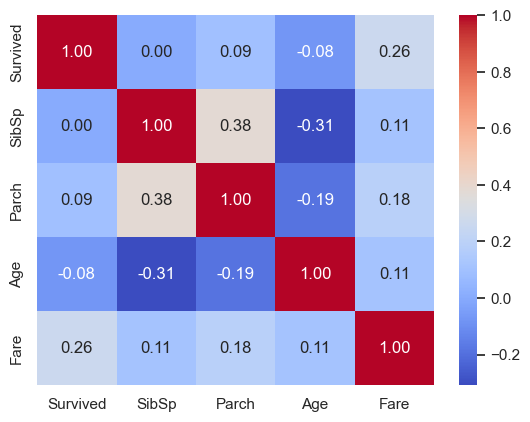

In [12]:
# correlation matrix between numerical values(SibSp Parch Age and Fare) and Survived
g = sns.heatmap(
    train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
)

Only Fare feature seems to have a significative corr with the survival prob.

It doesn't mean that the other fatures are not useful. Subpopulations in these features can  be correlated with the survival. To determine this, we need to explore in detail these features.

### SibSp

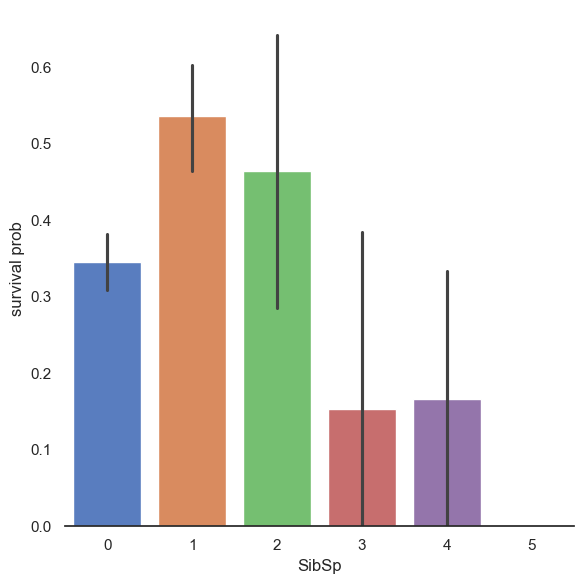

In [13]:
# Explore SibSp feature vs Survived
g = sns.catplot(
    x="SibSp",
    y="Survived",
    data=train,
    kind="bar",
    height=6,
    hue="SibSp",
    palette="muted",
    legend=False,
)
g.despine(left=True)  # 그래프 왼쪽 축선 제거
g = g.set_ylabels("survival prob")

It seems that passengers having a lot of siblings/spouses have less chance to survive.

Single passengers(0 SibSp) or with two other persons(SibSp 1 or 2) have more chance to survive.

This observations is quite interesting, we can consider a new feature decribing these categories(See feature engineering).

### Parch

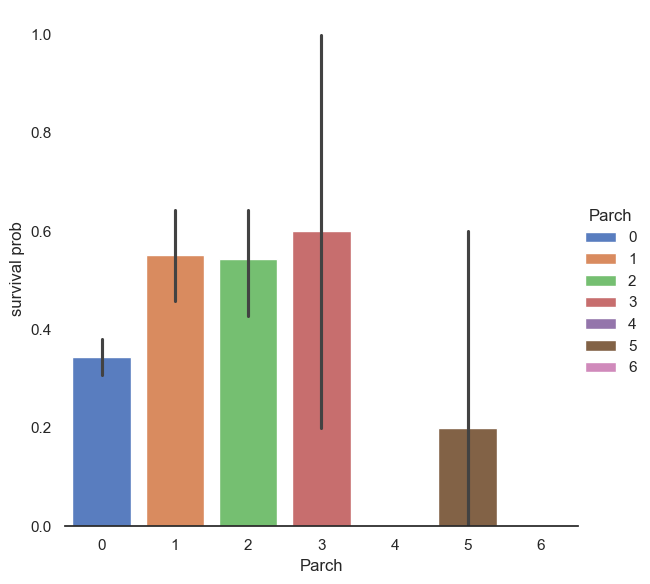

In [14]:
# Explore Parch feature vs Survived
g = sns.catplot(
    data=train,
    x="Parch",
    y="Survived",
    kind="bar",
    height=6,
    hue="Parch",
    palette="muted",
)
g.despine(left=True)
g = g.set_ylabels("survival prob")

Small families have more chance to survive more than single(Parch 0), medium(Parch 3, 4) and large families(Parch 5, 6).

Be careful there is an important standard deviation in the survival of passengers with 3 parents/children.

### Age

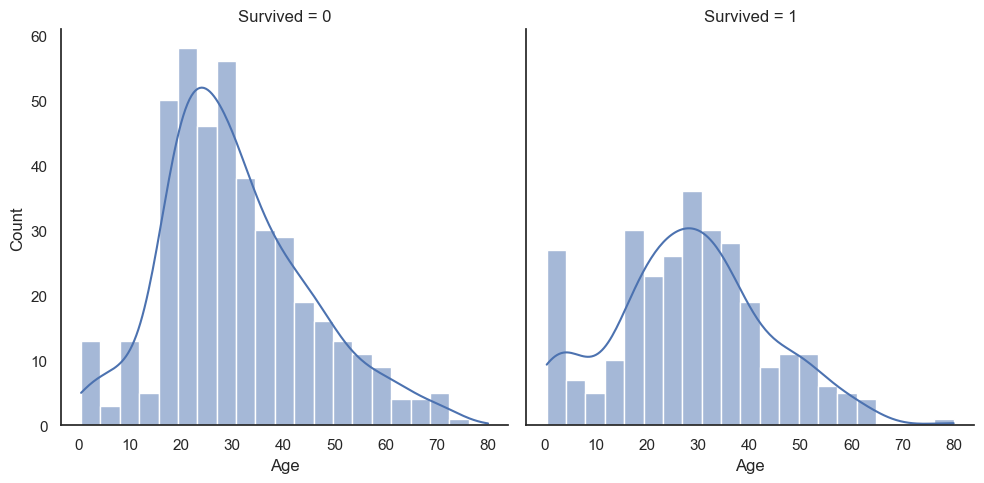

In [15]:
# Explore Age vs Survived
sns.displot(data=train, x="Age", col="Survived", kde=True)

Age dist seems to be a tailed dist, maybe a gaussian dist.

We notice that age dist are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60~80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

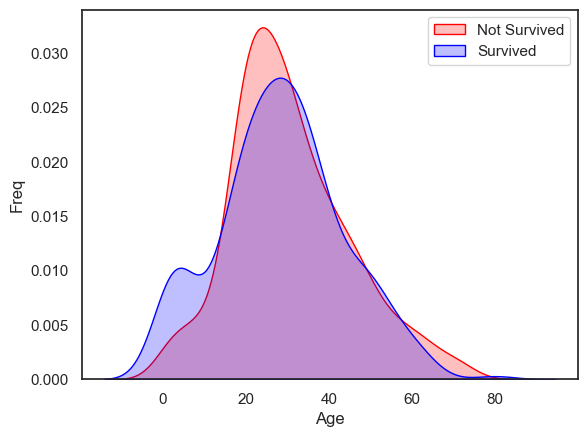

In [16]:
# Explore Age dist
g = sns.kdeplot(
    data=train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
    color="Red",
    fill=True,
)

g = sns.kdeplot(
    data=train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
    ax=g,
    color="Blue",
    fill=True,
)

g.set_xlabel("Age")
g.set_ylabel("Freq")
g = g.legend(["Not Survived", "Survived"])

When we superimpose the two densities, we clearly see a peak corresponding(between 0 and 5) to babies and very young childrens.

### Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Since we have one missing value, I decided to fill it with the median value which will not have an important effect on the pred.

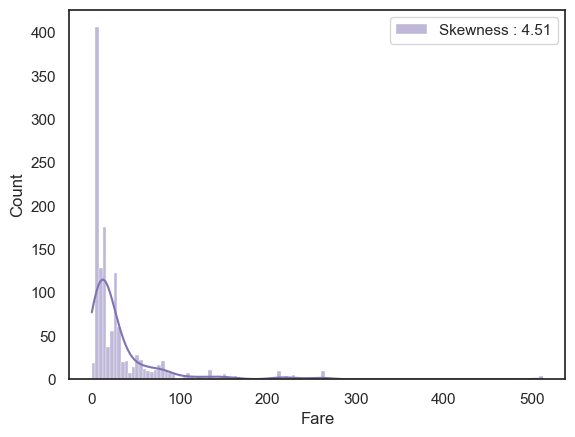

In [19]:
# Explore Fare dist
g = sns.histplot(
    dataset["Fare"],
    kde=True,
    color="m",
    label="Skewness : %.2f" % (dataset["Fare"].skew()),
)
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweight very high values in the model, even if it is scaled.

In [20]:
# Apply log to Fare to reduce skewness dist
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

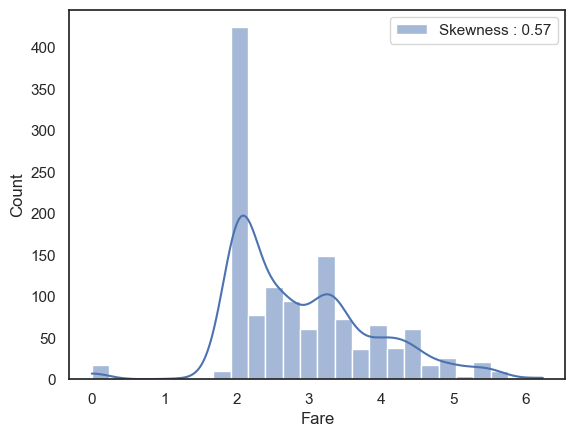

In [21]:
g = sns.histplot(
    data=dataset["Fare"],
    kde=True,
    color="b",
    label="Skewness : %.2f" % (dataset["Fare"].skew()),
)
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation.

## 3.2 Categorical values

### Sex

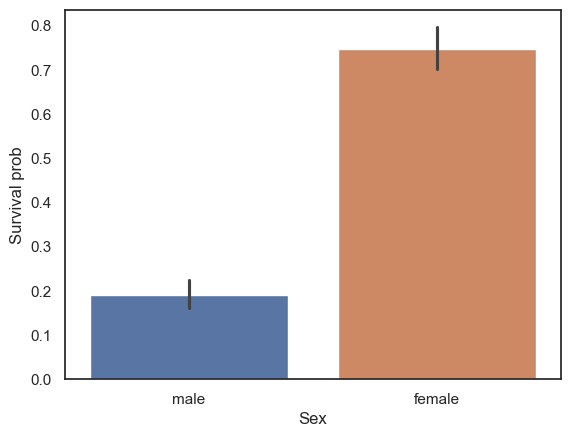

In [22]:
g = sns.barplot(x="Sex", y="Survived", data=train, hue="Sex")
g = g.set_ylabel("Survival prob")

In [23]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.

So Sex, might play an important role in the prediction of the survival.

For those who have seen the Titanic movie(1997), I am sure, we all remember this sentence during the evacuation : "Womend and children first".

### Pclass

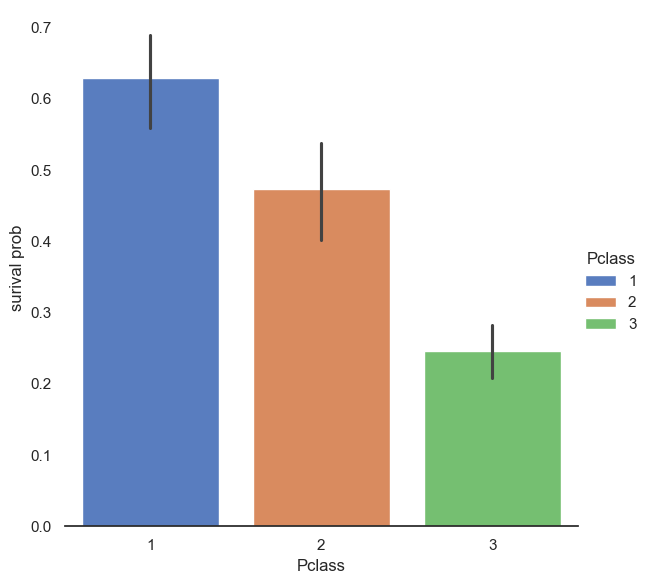

In [24]:
# Explore Pclass vs Survived
g = sns.catplot(
    data=train,
    x="Pclass",
    y="Survived",
    kind="bar",
    height=6,
    hue="Pclass",
    palette="muted",
)
g.despine(left=True)
g.set_ylabels("surival prob")

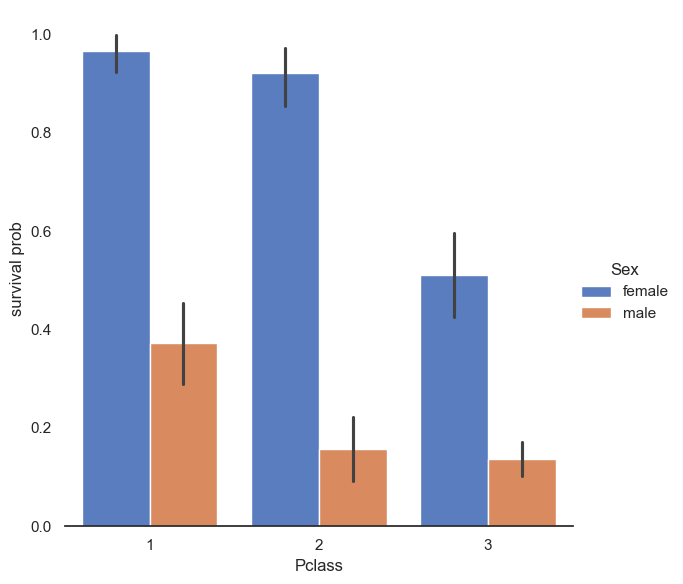

In [25]:
g = sns.catplot(
    data=train,
    x="Pclass",
    y="Survived",
    kind="bar",
    height=6,
    hue="Sex",
    palette="muted",
)
g.despine(left=True)
g.set_ylabels("survival prob")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we look at both male and female pasengers.

### Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
# Fill embarked nan values of dataset with 'S' most freq value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values, I decided to fill them with the most freq value of "Embarked" (S).

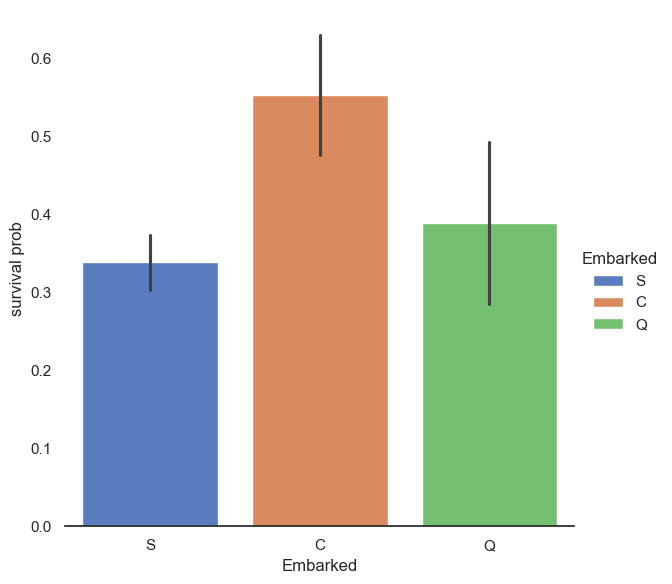

In [28]:
# Explore Embarked vs Survived
g = sns.catplot(
    data=train,
    x="Embarked",
    y="Survived",
    kind="bar",
    height=6,
    hue="Embarked",
    palette="muted",
)
g.despine(left=True)
g.set_ylabels("survival prob")

It seems that passenger coming from C have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from C than Q, S.

Let's see the Pclass dist vs Embarked.

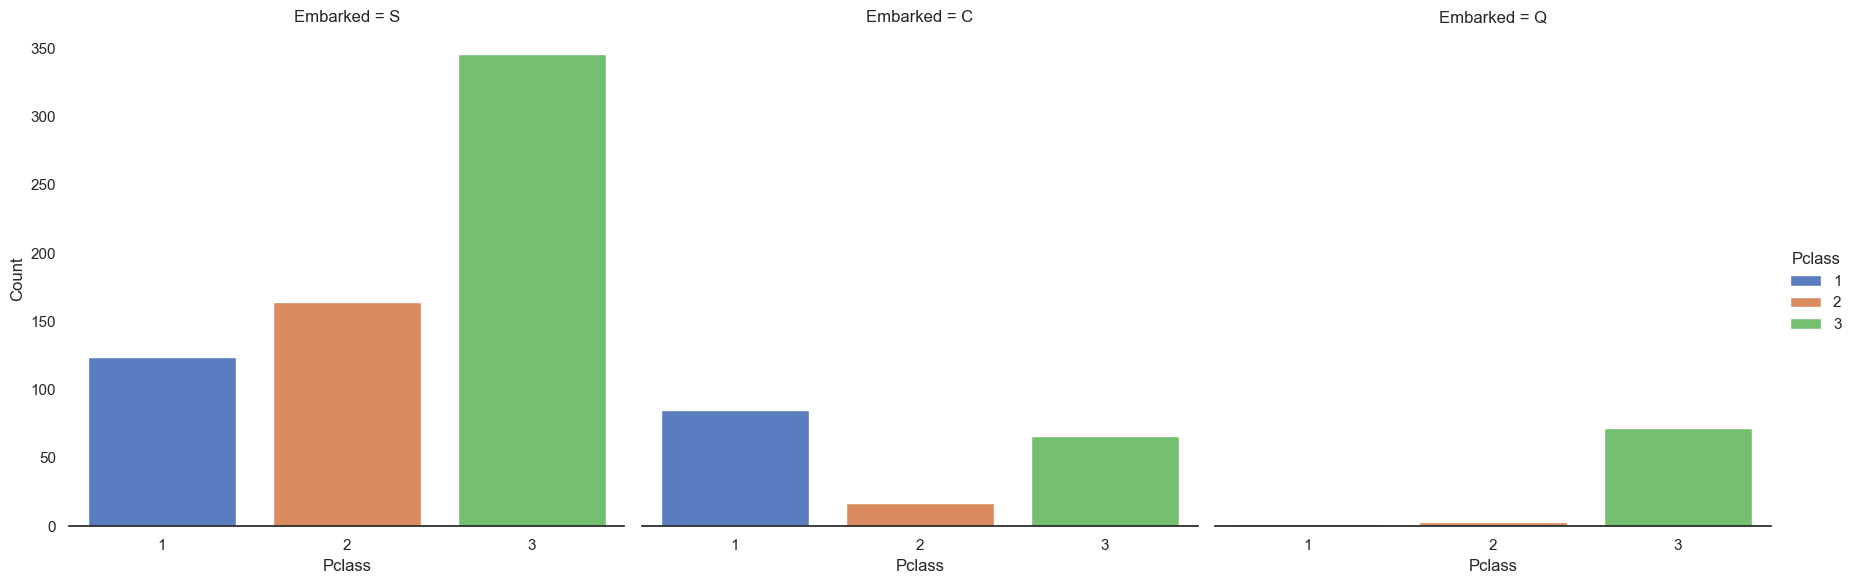

In [29]:
# Explore Pclass vs Embarked
g = sns.catplot(
    data=train,
    x="Pclass",
    kind="count",
    col="Embarked",
    height=6,
    hue="Pclass",
    palette="muted",
)
g.despine(left=True)
g.set_ylabels("Count")

Indeed, the third class is the most freq for passenger coming from S and Q, whereas C passengers are mostly in first class which have the highest survival rate.

At this point, I can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

# 4. Filling missing Values

## 4.1 Age

As we see, Age column contains 256 missing values in the whole dataset.

Since there is subpopulations that have more chance to survive(children for example), it is prefable to keep the age feature and to impute the missing values.

To address, this problem, I looked at the most correlated features with Age(Sex, Parch, Pclass  and SibSp).

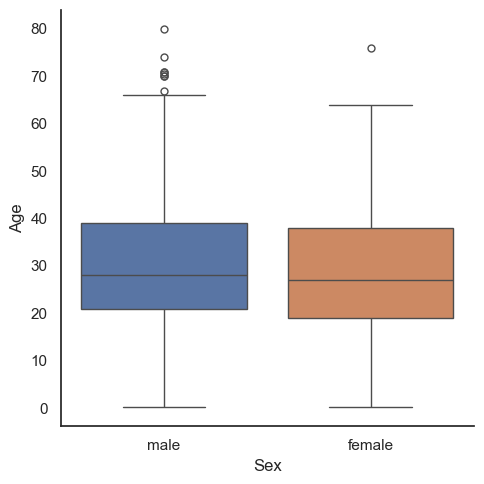

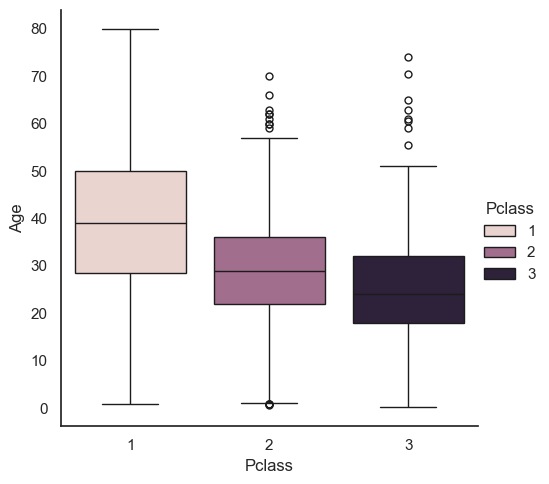

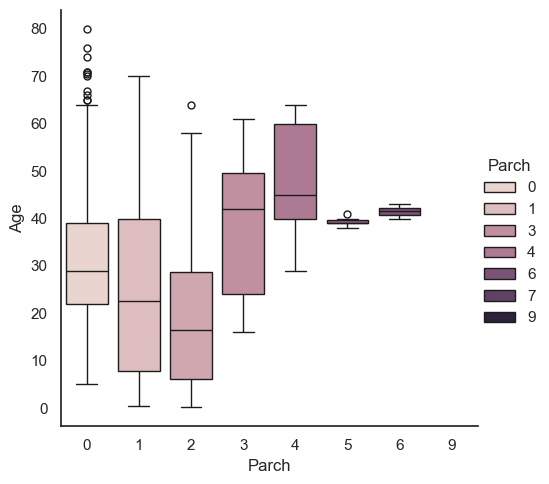

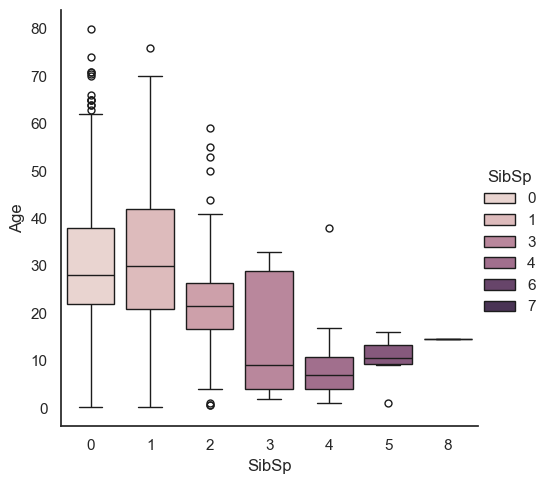

In [30]:
# Explore Age vs Sex, Parch, Pclass and SibSp
g = sns.catplot(data=dataset, x="Sex", y="Age", kind="box", hue="Sex")
g = sns.catplot(data=dataset, x="Pclass", y="Age", kind="box", hue="Pclass")
g = sns.catplot(data=dataset, x="Parch", y="Age", kind="box", hue="Parch")
g = sns.catplot(data=dataset, x="SibSp", y="Age", kind="box", hue="SibSp")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has sib/sp the younger he is.

In [31]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

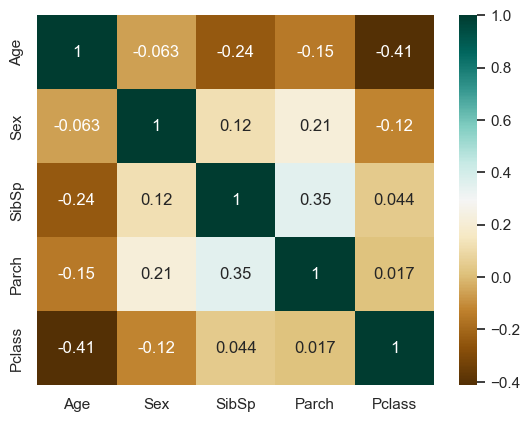

In [32]:
g = sns.heatmap(
    dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True
)

This correlation map confirms that catplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of par/ch. But the general correlation is negative.

So I decided to use SibSp, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [33]:
# Filling missing value of Age

# Fill Age with the medium age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][
        (
            (dataset["SibSp"] == dataset.iloc[i]["SibSp"])
            & (dataset["Parch"] == dataset.iloc[i]["Parch"])
            & (dataset["Pclass"] == dataset.iloc[i]["Pclass"])
        )
    ].median()

    if not np.isnan(age_pred):
        dataset.loc[i, "Age"] = age_pred
    else:
        dataset.loc[i, "Age"] = age_med

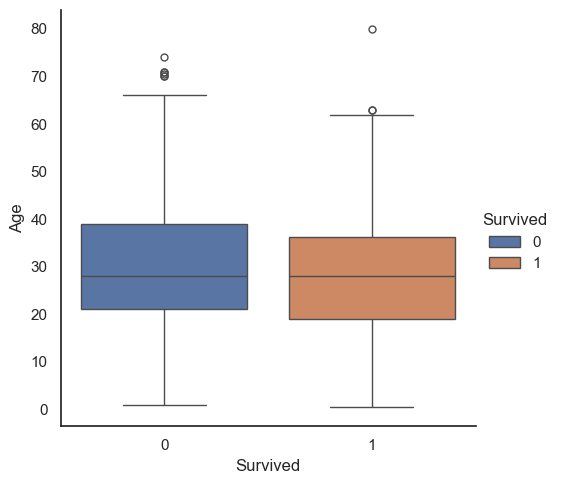

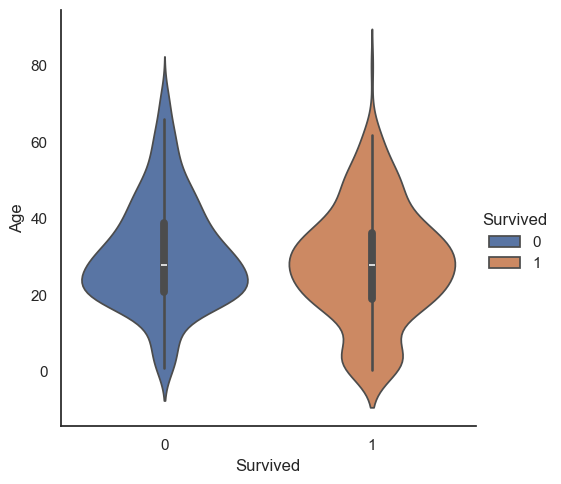

In [34]:
g = sns.catplot(data=train, x="Survived", y="Age", kind="box", hue="Survived")
g = sns.catplot(data=train, x="Survived", y="Age", kind="violin", hue="Survived")

No diff between median value of age in survived and not survived subpopulation.

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

# 5. Feature engineering

## 5.1 Name/Title

In [35]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains info on passenger's title.

Since some passenger with distinguished title may be preferred during the evacuation, it is interesting to add them to the model.

In [36]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

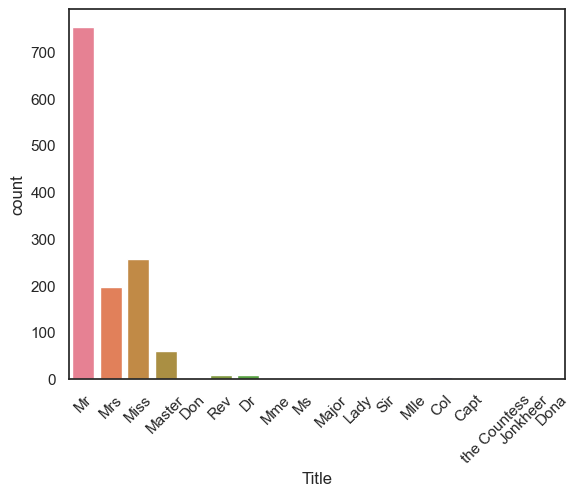

In [37]:
g = sns.countplot(x="Title", data=dataset, hue="Title")
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare we can group them in 4 categories.

In [38]:
dataset["Title"] = dataset["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
dataset["Title"] = (
    dataset["Title"]
    .replace(["Master"], "0")
    .replace(["Miss", "Ms", "Mme", "Mlle", "Mrs"], "1")
    .replace(["Mr"], "2")
    .replace(["Rare"], "3")
)

dataset["Title"] = dataset["Title"].astype(int)

In [39]:
dataset["Title"]

0       2
1       1
2       1
3       1
4       2
       ..
1294    2
1295    3
1296    2
1297    2
1298    0
Name: Title, Length: 1299, dtype: int32

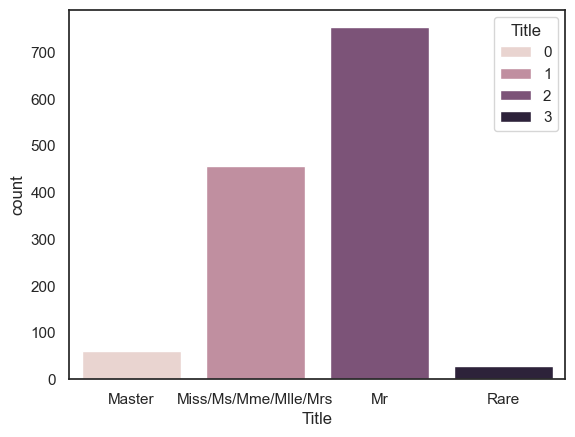

In [40]:
g = sns.countplot(data=dataset, x="Title", hue="Title")
g.set_xticks([0, 1, 2, 3])
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
plt.show()

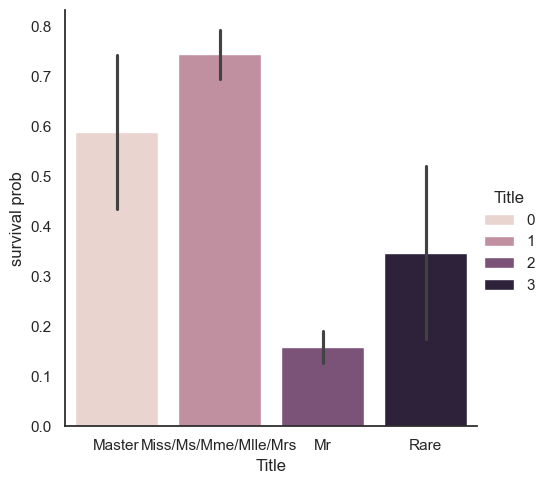

In [41]:
g = sns.catplot(data=dataset, x="Title", y="Survived", kind="bar", hue="Title")
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
g.set_ylabels("survival prob")

"Women and children first"

It is interesting to note that passengers with rare title have more chance to survive.

In [42]:
# Drop Name Variable
dataset.drop(labels=["Name"], axis=1, inplace=True)

## 5.2 Family Size

We can imagine that large families will have more difficulties to evacuate, looking for their sisters/brothers/parents during the evacuation. So, I choosed to create a "Fsize"(Family size) feature which is the sum of SibSp, Parch and 1.

In [43]:
# Create a family size decriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

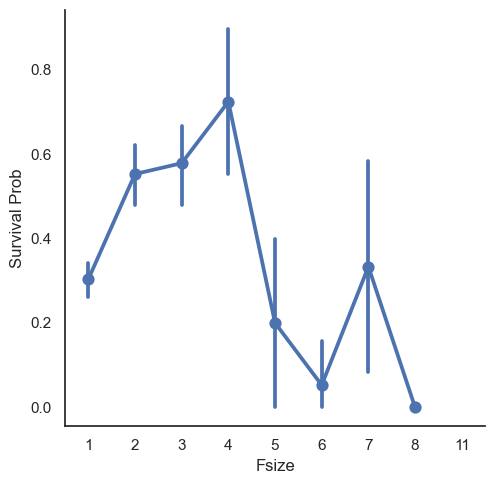

In [44]:
g = sns.catplot(data=dataset, x="Fsize", y="Survived", kind="point")
g.set_ylabels("Survival Prob")

The family size seems to play an important role, survival prob is worst for large families.

Additionally, I decided to created 4 categories of family size.

In [45]:
# Create new feature of family size
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

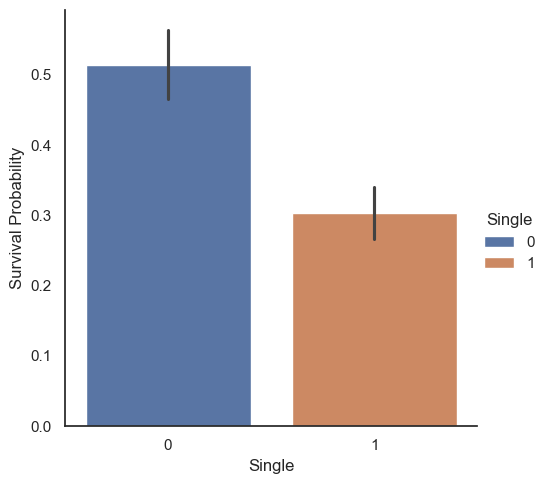

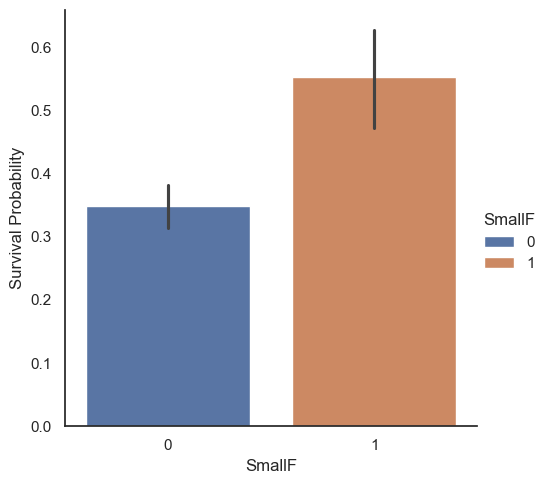

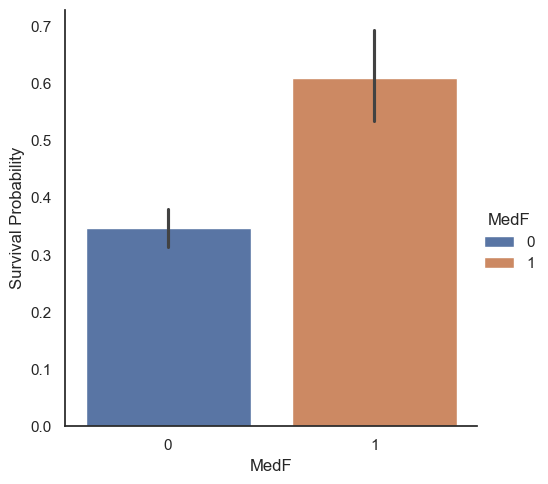

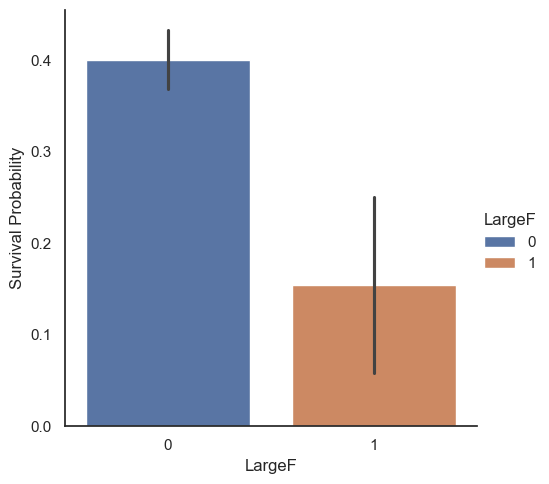

In [46]:
g = sns.catplot(data=dataset, x="Single", y="Survived", kind="bar", hue="Single")
g.set_ylabels("Survival Probability")

g = sns.catplot(data=dataset, x="SmallF", y="Survived", kind="bar", hue="SmallF")
g.set_ylabels("Survival Probability")

g = sns.catplot(data=dataset, x="MedF", y="Survived", kind="bar", hue="MedF")
g.set_ylabels("Survival Probability")

g = sns.catplot(data=dataset, x="LargeF", y="Survived", kind="bar", hue="LargeF")
g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [47]:
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


At this stage, we have 22 features.

## 5.3 Cabin

In [48]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature col contains 292 vals and 1007 missing vals.

I supposed that passengers without a cabin have a missing val displayed instead of the cabin number.

In [51]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"]]
)

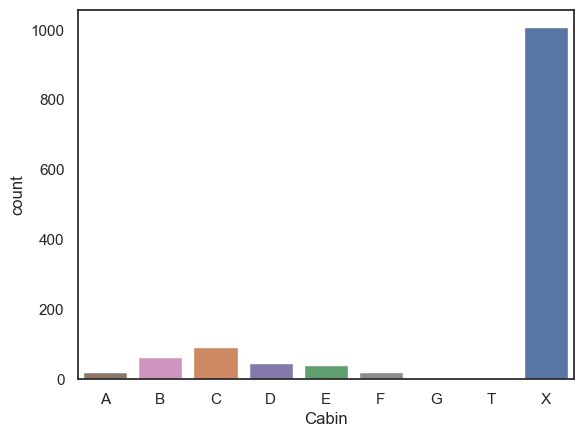

In [53]:
g = sns.countplot(
    data=dataset,
    x="Cabin",
    order=["A", "B", "C", "D", "E", "F", "G", "T", "X"],
    hue="Cabin",
)

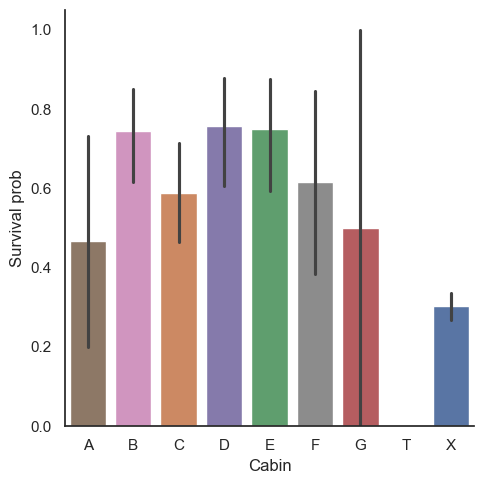

In [54]:
g = sns.catplot(
    data=dataset,
    x="Cabin",
    y="Survived",
    kind="bar",
    order=["A", "B", "C", "D", "E", "F", "G", "T", "X"],
    hue="Cabin",
)
g.set_ylabels("Survival prob")

Because of the low number of passenger that have a cabin, survival prob have an important standard deviation and we can't distinguish between survival prob of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without(X).

It is praticularly true for cabin B, C, D, E and F.

In [55]:
dataset = pd.get_dummies(data=dataset, columns=["Cabin"], prefix="Cabin")

## 5.4 Ticket

In [56]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So I decided to replace the Ticket feature col by the ticket prefix. Which may be more informative.

In [57]:
# Treat ticket by extracting the ticket prefix. When there is no prefix it returns X

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(" ")[0])
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [59]:
# Create categorical vals for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [60]:
# Drop useless variables
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True
